In [8]:
# Import libraries
import pandas
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

## Basic Variables

In [9]:
data_repo_loc = '../../COVID-19'
case_data_loc = f'{data_repo_loc}/csse_covid_19_data'
report_loc = f'{case_data_loc}/csse_covid_19_daily_reports'

months = {1:[22,31], 2:[1,29], 3:[1,31]}

states_analyzed = {'NY':'New York', 'NJ':'New Jersey', 'PA':'Pennsylvania', 'MA':'Massachusetts', 'CA':'California', 'OR':'Oregon', 'WA':'Washington', 'TX' : 'Texas', 'CO' : 'Colorado'}

## Accessing Basic Data

In [13]:
def import_data(skip_months=[]):
    """High level pre-processing of data from the John Hopkins repo"""
    df_list = []
    
    # Read in each file, looping over the month and days as they are the file names
    for month in months:
        # Some months may be skipped for simple data reduction
        if month in skip_months:
            continue

        # Create a string of the month for the file name
        if month < 10:
            m_str = f'0{month}'
        else:
            m_str = str(month)
            
        for day in range(months[month][0], months[month][1]+1):
            
            # Create a string of the month for the file name
            if day < 10:
                d_str = f'0{day}'
            else:
                d_str = str(day)
            
            # Read in the day's file
            file = f'{m_str}-{d_str}-2020.csv'
            df_day = pandas.read_csv(f'{report_loc}/{file}')

            # Ensure the same headers for all DFs
            columns = df_day.columns
            renames ={}
            if 'Country_Region' in columns:
                renames['Country_Region'] = 'Country/Region'
            if 'Province_State' in columns:
                renames['Province_State'] = 'Province/State'
            if 'Last_Update' in columns:
                renames['Last_Update'] = 'Last Update'
            if 'Long_' in columns:
                renames['Long_'] = 'Longitude'
            if 'Lat' in columns:
                renames['Lat'] = 'Latitude'
            if len(renames) > 0:
                df_day.rename(columns=renames, inplace=True)
                
            # Convert the date into a "day of the year" number and add as a column
            ytd = 0
            for m in range(1, month):
                ytd += months[m][1]
            ytd += day
            
            # Actually, use the date string instead
            df_day['Day'] = f'{m_str}-{d_str}'
            
            # Add the edited day DF to the list of all of them, to be merged
            df_list.append(df_day)
    
    # Merge all the DFs into one
    df_all = pandas.concat(df_list)
    
    # Remove unneeded columns
    df_all.drop(['Last Update', 'Latitude', 'Longitude', 'Combined_Key', 'FIPS'], axis=1, inplace=True)
    
    # Move to new default sorting
    #df_all.sort_values(by=['Country/Region', 'Province/State', 'Day', 'Admin2'], inplace=True)
    
    return df_all

def sort_usa_data(df_all):
    """Get USA data, and separate out counties/cities from states for old data"""
    
    # Grab just the USA
    df_usa = df_all[df_all['Country/Region'] == 'US']
    
    # Remove 'Province/' from column name, as well as the Country column
    df_usa.rename(columns={'Province/State':'State'}, inplace=True)
    df_usa.drop(['Country/Region'], axis=1, inplace=True)
    
    df_usa.reset_index(inplace=True)
    
    # Need to split out the county and state since older data combined the two
    for index, row in df_usa.iterrows():
        if ',' in row['State']:
            cnty, st = row['State'].split(', ')
            df_usa.at[index,'Admin2'] = cnty
            if st in states_analyzed.keys():
                st = states_analyzed[st]
            df_usa.at[index,'State'] = st
    
    # Sort the data and export
    df_usa.sort_values(by=[ 'Day', 'State', 'Admin2'], inplace=True)
    df_usa.to_csv('USA.csv')
    
    return df_usa

def sum_state(df_usa, state):
    """Collapse data down for each state"""
    # Grab the data for the individual state
    print(f'Separating and summing {state}')
    df_state = df_usa[df_usa['State'] == state]
    df_state.to_csv(f'{state}.csv')

    # Sum the data into singular sets for each day, ignoring counties
    days = df_state.groupby('Day', axis=0).sum()
    
    # Calculate number of active cases and death rate, and add them
    active = []
    death_rate = []
    for i, row in days.iterrows():
        active.append(row['Confirmed'] - row['Deaths'] - row['Recovered'])
        death_rate.append(row['Deaths']/row['Confirmed'])
    days['Active'] = active
    days['Death Rate'] = death_rate
    
    return days

def get_state_data(df_usa, states=states_analyzed.values(), data='Confirmed'):
    """Get a type of data for each state requested"""
    df_states = pandas.DataFrame()

    for state in states:
        df_state = sum_state(df_usa, state)
        df_states[state] = df_state[data]
    return df_states

## Get The Basic USA Data

In [16]:
df_all = import_data(skip_months=[1])
df_usa = sort_usa_data(df_all)

/home/thor/anaconda3/envs/and/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thor/anaconda3/envs/and/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thor/anaconda3/envs/and/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Graph the numbers and rates for select states

Separating and summing New York
Separating and summing New Jersey
Separating and summing Pennsylvania
Separating and summing Massachusetts
Separating and summing California
Separating and summing Oregon
Separating and summing Washington
Separating and summing Texas
Separating and summing Colorado


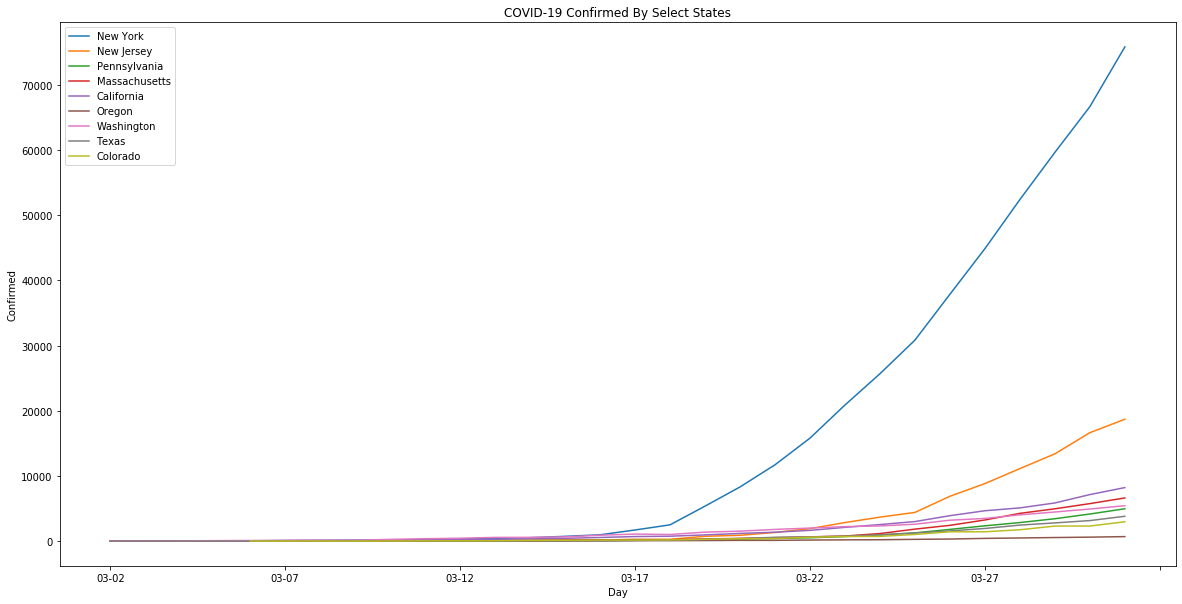

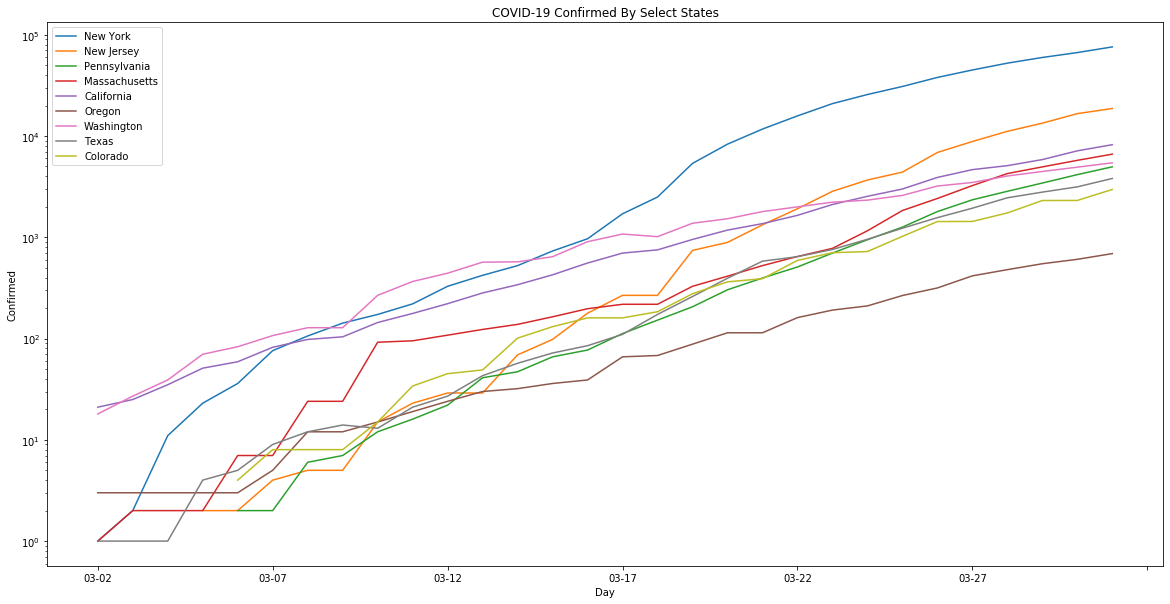

Separating and summing New York
Separating and summing New Jersey
Separating and summing Pennsylvania
Separating and summing Massachusetts
Separating and summing California
Separating and summing Oregon
Separating and summing Washington
Separating and summing Texas
Separating and summing Colorado


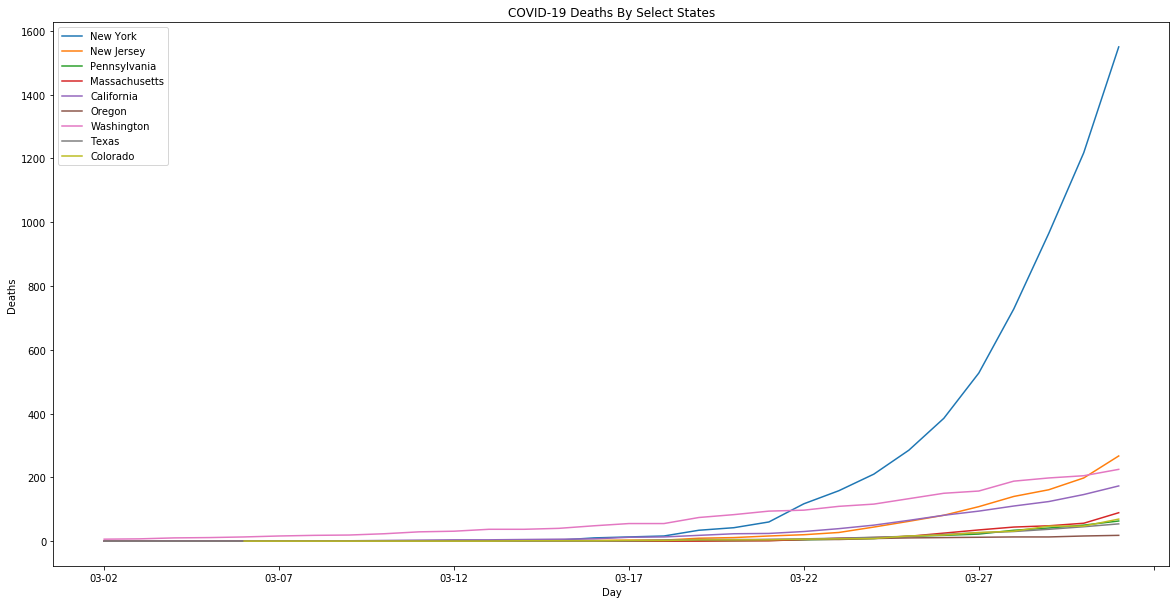

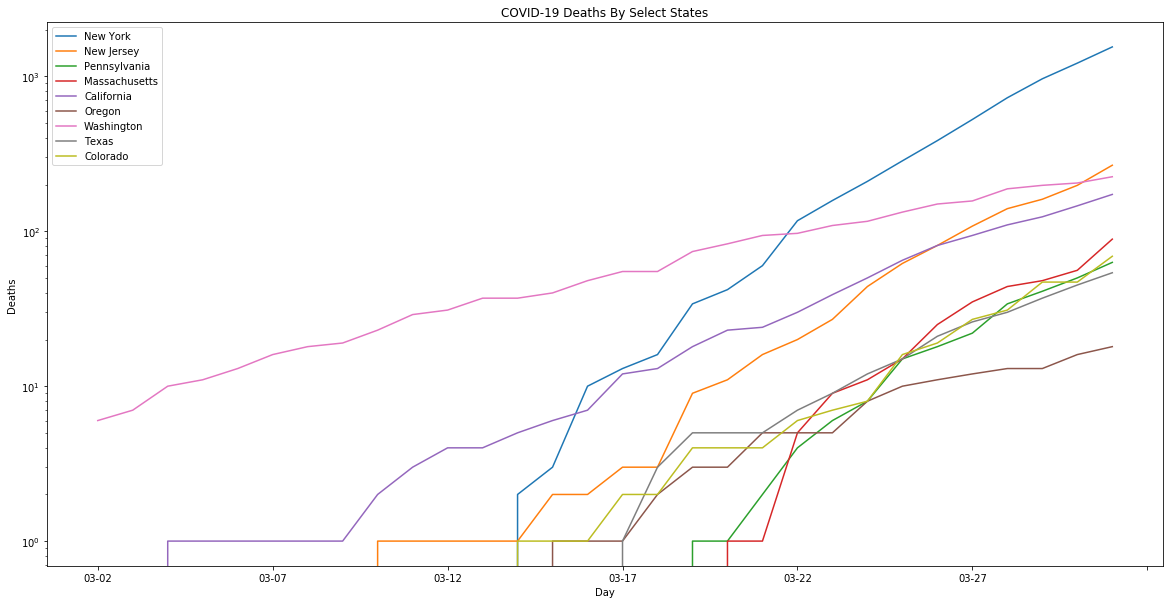

Separating and summing New York
Separating and summing New Jersey
Separating and summing Pennsylvania
Separating and summing Massachusetts
Separating and summing California
Separating and summing Oregon
Separating and summing Washington
Separating and summing Texas
Separating and summing Colorado


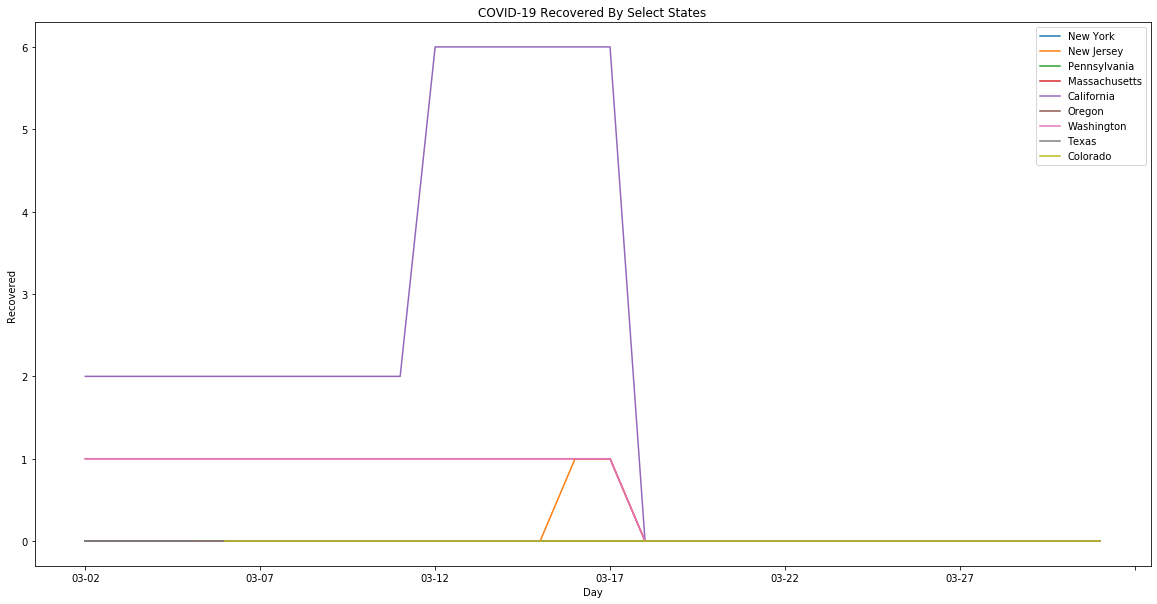

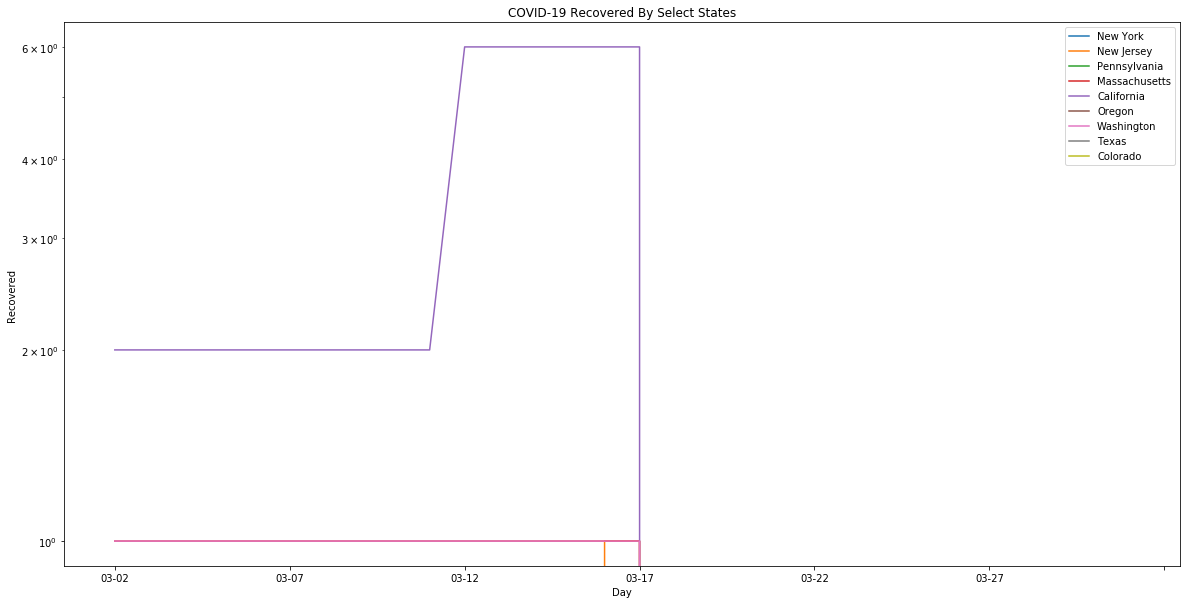

Separating and summing New York
Separating and summing New Jersey
Separating and summing Pennsylvania
Separating and summing Massachusetts
Separating and summing California
Separating and summing Oregon
Separating and summing Washington
Separating and summing Texas
Separating and summing Colorado


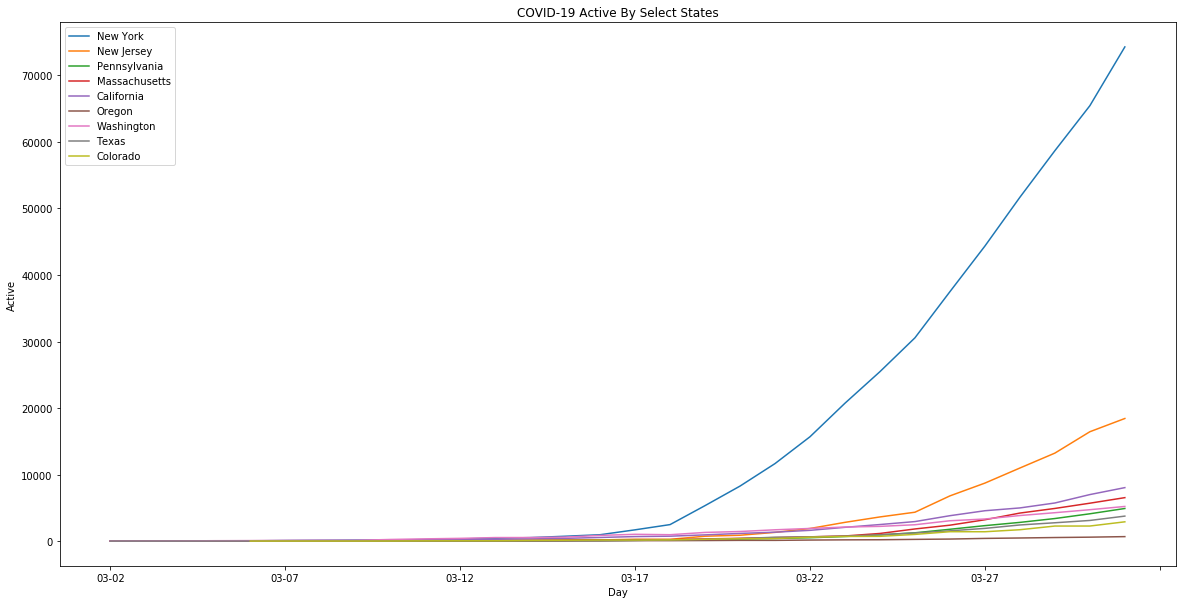

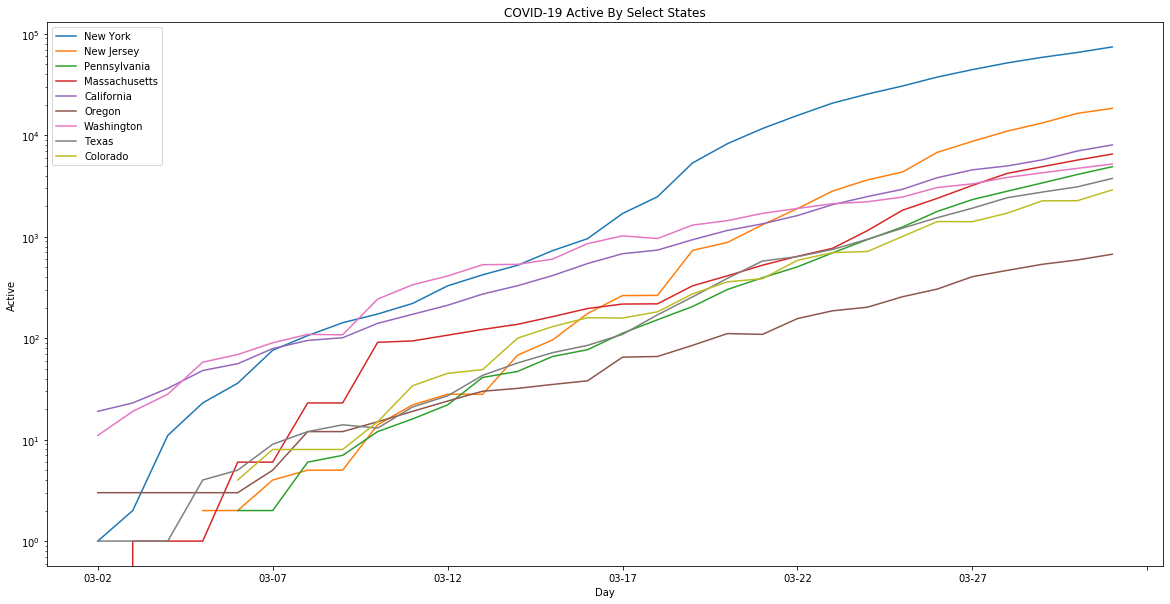

Separating and summing New York
Separating and summing New Jersey
Separating and summing Pennsylvania
Separating and summing Massachusetts
Separating and summing California
Separating and summing Oregon
Separating and summing Washington
Separating and summing Texas
Separating and summing Colorado


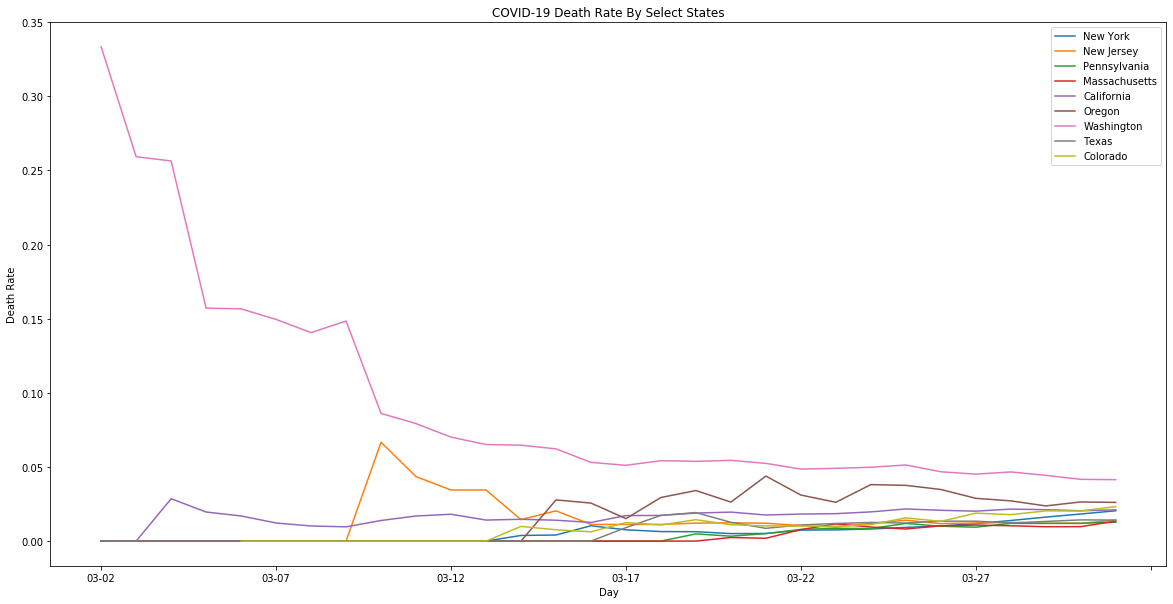

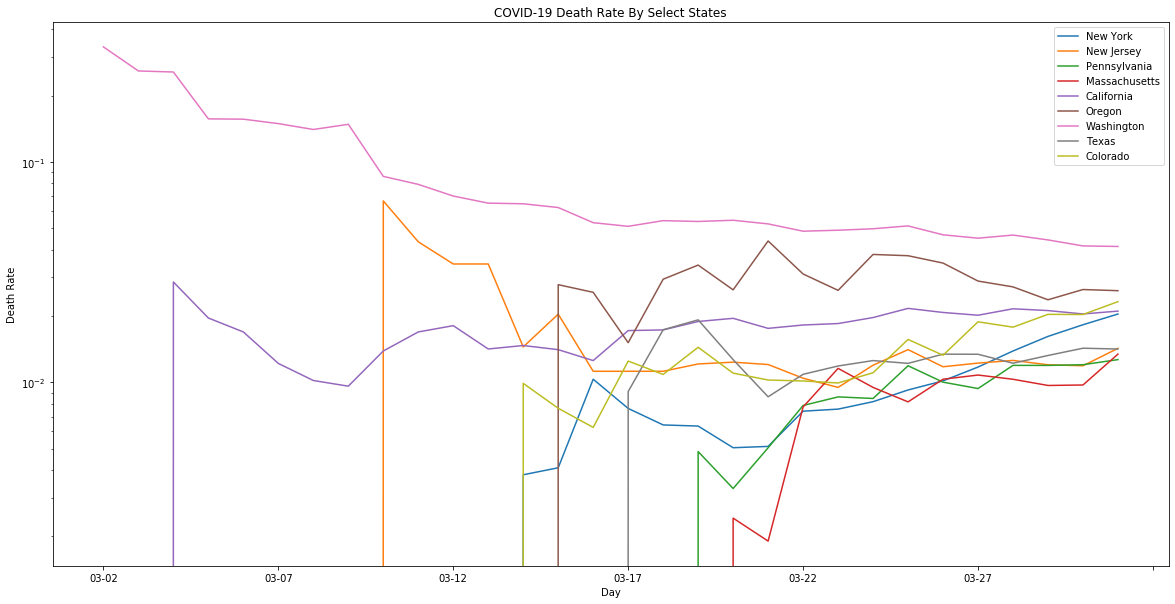

In [17]:
for data in ['Confirmed', 'Deaths', 'Recovered', 'Active', 'Death Rate']:
    df_cases = get_state_data(df_usa, data=data)
    df_cases.to_csv(f'covid-states-{data.lower()}.csv')
    for scale in ['linear', 'log']:
        df_cases.plot(kind='line', figsize=(20,10))
        
        plt.title(f'COVID-19 {data} By Select States')
        plt.yscale(scale)
        
        plt.ylabel(data)
        plt.xlabel('Day')
        
        plt.savefig(f'covid-{data}-({scale}).png')
        plt.show()
